In [ ]:
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import os, shutil

2025-06-12 23:08:50.318050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749766130.449361     565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749766130.483198     565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749766130.745043     565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749766130.745071     565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749766130.745074     565 computation_placer.cc:177] computation placer alr

# Funções

In [ ]:
def get_true_pred(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset.unbatch().batch(1):
        y_true.append(np.argmax(labels.numpy()))
        pred = model.predict(images, verbose=0)
        y_pred.append(np.argmax(pred))
    return np.array(y_true), np.array(y_pred)

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

## Carregamento do dataset
Carrega o dataset distribuido pelos diferentes conjuntos de dados.

In [ ]:
train_dir = 'Dataset/archive/seg_train'
validation_dir = 'Dataset/archive/seg_val'
test_dir = 'Dataset/archive/seg_test'

train_buildings_dir = 'Dataset/archive/seg_train/buildings/'
train_forest_dir = 'Dataset/archive/seg_train/forest'
train_glacier_dir = 'Dataset/archive/seg_train/glacier'
train_mountain_dir = 'Dataset/archive/seg_train/mountain'
train_sea_dir = 'Dataset/archive/seg_train/sea'
train_street_dir = 'Dataset/archive/seg_train/street'

val_buildings_dir = 'Dataset/archive/seg_val/buildings'
val_forest_dir = 'Dataset/archive/seg_val/forest'
val_glacier_dir = 'Dataset/archive/seg_val/glacier'
val_mountain_dir = 'Dataset/archive/seg_val/mountain'
val_sea_dir = 'Dataset/archive/seg_val/sea'
val_street_dir = 'Dataset/archive/seg_val/street'

test_buildings_dir = 'Dataset/archive/seg_test/buildings'
test_forest_dir = 'Dataset/archive/seg_test/forest'
test_glacier_dir = 'Dataset/archive/seg_test/glacier'
test_mountain_dir = 'Dataset/archive/seg_test/mountain'
test_sea_dir = 'Dataset/archive/seg_test/sea'
test_street_dir = 'Dataset/archive/seg_test/street'

print('total training buildings images:', len(os.listdir(train_buildings_dir)))
print('total training forest images:', len(os.listdir(train_forest_dir)))
print('total training glacier images:', len(os.listdir(train_glacier_dir)))
print('total training mountain images:', len(os.listdir(train_mountain_dir)))
print('total training sea images:', len(os.listdir(train_sea_dir)))
print('total training street images:', len(os.listdir(train_street_dir)))

print('total validation buildings images:', len(os.listdir(val_buildings_dir)))
print('total validation forest images:', len(os.listdir(val_forest_dir)))
print('total validation glacier images:', len(os.listdir(val_glacier_dir)))
print('total validation mountain images:', len(os.listdir(val_mountain_dir)))
print('total validation sea images:', len(os.listdir(val_sea_dir)))
print('total validation street images:', len(os.listdir(val_street_dir)))

print('total test buildings images:', len(os.listdir(test_buildings_dir)))
print('total test forest images:', len(os.listdir(test_forest_dir)))
print('total test glacier images:', len(os.listdir(test_glacier_dir)))
print('total test mountain images:', len(os.listdir(test_mountain_dir)))
print('total test sea images:', len(os.listdir(test_sea_dir)))
print('total test street images:', len(os.listdir(test_street_dir)))

total training buildings images: 1691
total training forest images: 1771
total training glacier images: 1904
total training mountain images: 2012
total training sea images: 1774
total training street images: 1882
total validation buildings images: 500
total validation forest images: 500
total validation glacier images: 500
total validation mountain images: 500
total validation sea images: 500
total validation street images: 500
total test buildings images: 437
total test forest images: 474
total test glacier images: 553
total test mountain images: 525
total test sea images: 510
total test street images: 501


## Distribuição de imagens por classe e por conjunto de dados
As imagens estão distribuidas por 3 conjuntos de dados: train, validation e test.
Cada um desses conjuntos está distribuido por 6 classes: buildings, forest, glacier, mountain, sea e street.

### Número total de imagens por classe:

| Classe     | Treino | Validação | Teste | Total |
|------------|--------|-----------|-------|-------|
| Buildings  | 1691   | 500       | 437   | 2628  |
| Forest     | 1771   | 500       | 474   | 2745  |
| Glacier    | 1904   | 500       | 553   | 2957  |
| Mountain   | 2012   | 500       | 525   | 3037  |
| Sea        | 1774   | 500       | 510   | 2784  |
| Street     | 1882   | 500       | 501   | 2883  |
| **Total**  | **11034** | **3000** | **3000** | **17034** |

### Número total de imagens por conjunto de dados:

| Conjunto de dados | Total |
|-------------------|-------|
| Treino            | 11034 |
| Validação         | 3000  |
| Teste             | 3000  |
| **Total geral**   | **17034** |


## Processamento dos dados

 Carrega, redimensiona e organiza imagens em batches com rótulos one-hot, preparando os dados de treino, validação e teste.

In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 32

# Processing the data
train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

print(test_dataset)
class_names = train_dataset.class_names
print("Classes:", class_names)

Found 11034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Carregamento do modelo VGG16

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Feature extraction without data augmentation

## Extração de Features e Labels dos conjuntos de dados


In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

I0000 00:00:1749666649.546561   81960 service.cc:152] XLA service 0x7d7338004590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749666649.546628   81960 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-06-11 19:30:49.556141: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749666649.641743   81960 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 19:30:52.603001: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,150,150]{3,2,1,0} %bitcast.396, f32[64,3,3,3]{3,2,1,0} %bitcast.403, f32[64]{0} %bitcast.405), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


I0000 00:00:1749666658.422950   81960 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025-06-11 19:31:58.268656: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[26,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[26,3,150,150]{3,2,1,0} %bitcast.396, f32[64,3,3,3]{3,2,1,0} %bitcast.403, f32[64]{0} %bitcast.405), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="vgg16_1/block1_conv1_1/convolution" source_file="/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-11 19:31:58.480735: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omi

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-06-11 19:32:02.969148: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━

2025-06-11 19:32:18.072499: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[24,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,150,150]{3,2,1,0} %bitcast.396, f32[64,3,3,3]{3,2,1,0} %bitcast.403, f32[64]{0} %bitcast.405), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="vgg16_1/block1_conv1_1/convolution" source_file="/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-11 19:32:18.297624: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omi

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2025-06-11 19:32:25.678946: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━

## Guardar features e labels dos conjuntos de dados


In [ ]:
np.save('modelT_train_features.npy', train_features)
np.save('modelT_train_labels.npy', train_labels)
np.save('modelT_val_features.npy', val_features)
np.save('modelT_val_labels.npy', val_labels)
np.save('modelT_test_features.npy', test_features)
np.save('modelT_test_labels.npy', test_labels)

train_features = np.load('modelT_train_features.npy')
train_labels = np.load('modelT_train_labels.npy')
val_features = np.load('modelT_val_features.npy')
val_labels = np.load('modelT_val_labels.npy')
test_features = np.load('modelT_test_features.npy')
test_labels = np.load('modelT_test_labels.npy')

## Criação da CNN para VGG16
Este bloco define a head da rede que será acoplada ao VGG16 pré-treinado, assumindo que a saída do VGG16 tem forma (4, 4, 512). A arquitetura inclui uma camada Flatten, uma camada densa com 256 unidades e ativação ReLU, seguida de Dropout para reduzir overfitting, e termina com uma camada Dense com ativação softmax para realizar a classificação multiclasse.

In [ ]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)

## Compilação da CNN
Compilação da CNN utilizando a loss **KLDivergence** e o optimizer **RMSprop**.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Definição do callback
Definição de um callback que guarda automaticamente o modelo com a menor perda (loss) de validação durante o treino.

In [ ]:
checkpoint_filepath = 'modelT_featureExtraction_head.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

## Treino da CNN
Treino do modelo durante 50 épocas com os features e labels extraídos.

In [ ]:
print('Is eager: ', tf.executing_eagerly())
history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=[model_checkpoint_callback])

Is eager:  True
Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7081 - loss: 4.2651 - val_accuracy: 0.8913 - val_loss: 0.8341
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8830 - loss: 0.8522 - val_accuracy: 0.9010 - val_loss: 0.5949
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9132 - loss: 0.4457 - val_accuracy: 0.9093 - val_loss: 0.5856
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9392 - loss: 0.2887 - val_accuracy: 0.9120 - val_loss: 0.5677
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9446 - loss: 0.2248 - val_accuracy: 0.9113 - val_loss: 0.6040
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9618 - loss: 0.1875 - val_accuracy: 0.9160 - val_loss: 0.6353
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9660 - loss: 0.1452 - val_accuracy: 0.9143 - val_loss: 0.6442
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9694 - loss: 0.1130 

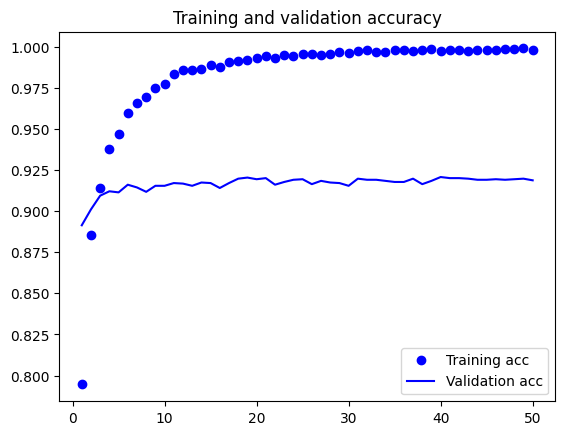

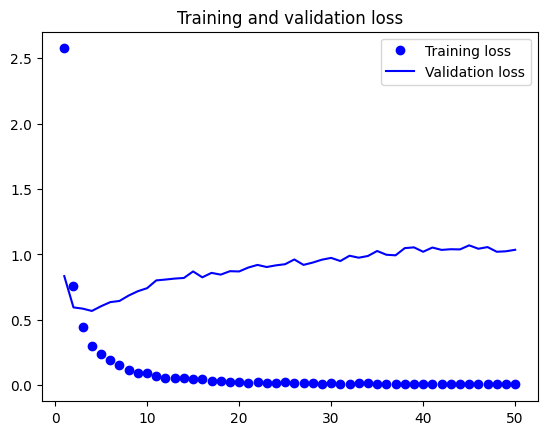

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Criação da CNN com vgg16
 Criação do modelo completo combinando o VGG16 pré-treinado (conv_base) com o modelo definido anteriormente.

In [ ]:
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

## Compilação da CNN
Compilação da CNN utilizando a loss **categorical crossentropy** e o optimizer **RMSprop**.

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Guardar modelo

In [ ]:
full_model.save('modelT_featureExtraction_full.keras')

## Carregamento do modelo e validação
Carregamento e avaliação do modelo através do valor da accuracy.

In [ ]:
full_model = keras.models.load_model('modelT_featureExtraction_full.keras')
val_loss, val_acc = full_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1749766223.526179     649 service.cc:152] XLA service 0x72486c006e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749766223.526245     649 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-06-12 23:10:23.583936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-12 23:10:24.182179: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,150,150]{3,2

 2/94 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8828 - loss: 1.9134 

I0000 00:00:1749766231.221100     649 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9121 - loss: 1.2389

2025-06-12 23:10:38.675693: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[24,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,150,150]{3,2,1,0} %bitcast.850, f32[64,3,3,3]{3,2,1,0} %bitcast.857, f32[64]{0} %bitcast.859), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-12 23:10:38.940932: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9122 - loss: 1.2346
val_acc: 0.918666660785675


## Computing the model output for one image

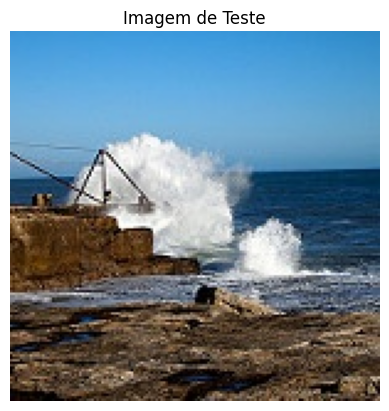

2025-06-11 19:35:30.338582: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[1,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,150,150]{3,2,1,0} %bitcast.543, f32[64,3,3,3]{3,2,1,0} %bitcast.550, f32[64]{0} %bitcast.552), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-11 19:35:30.421542: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picke

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probabilidades por classe:
 buildings: 0.0000
    forest: 0.0000
   glacier: 0.0000
  mountain: 0.0000
       sea: 1.0000
    street: 0.0000

Classe prevista: sea (1.0000)


In [ ]:
from PIL import Image
img_path = 'Dataset/archive/seg_test/sea/20072.jpg'

img = tf.keras.preprocessing.image.load_img(
    img_path,
    target_size=(150, 150),
    interpolation='bilinear'
)

plt.imshow(img)
plt.axis('off')
plt.title("Imagem de Teste")
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

result = full_model.predict(img_array)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print("Probabilidades por classe:")
for i, prob in enumerate(result[0]):
    print(f"{class_names[i]:>10s}: {prob:.4f}")

predicted_class = np.argmax(result)
print(f"\nClasse prevista: {class_names[predicted_class]} ({result[0][predicted_class]:.4f})")


# Feature extraction with data augmentation

In [ ]:
conv_base_DA = VGG16(weights="imagenet", include_top=False)
conv_base_DA.trainable = False

## Data augmentation
Criação de data augmentation que aplica transformações aleatórias às imagens durante o treino, incluindo inversão horizontal, pequenas rotações e zoom, com o objetivo de aumentar a variabilidade dos dados e melhorar a generalização do modelo.

In [ ]:
data_augmentation = keras.Sequential([
     layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

## Criação da CNN
Criação do modelo completo com base no VGG16 pré-treinado, incluindo uma etapa inicial de data augmentation, seguida do pré-processamento específico do VGG16. A saída do conv_base_DA é passada por camadas Flatten, Dense e Dropout, terminando com uma camada softmax para classificação multiclasse.

In [ ]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
\
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_DA = keras.Model(inputs, outputs)

## Compilação da CNN
Compilação da CNN utilizando a loss **categorical crossentropy** e o optimizer **RMSprop**.

In [ ]:
model_DA.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Definição do callback
Definição de um callback que guarda automaticamente o modelo com a menor perda (loss) de validação durante o treino.

In [ ]:
checkpoint_filepath_DA = 'modelT_featureExtraction_DataAugmentation.keras'
model_checkpoint_callback_DA = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_DA,
    monitor='val_loss',
    save_best_only=True)

## Treino da CNN
Treino do modelo durante 50 épocas com os features e labels extraídos.

In [ ]:
tf.config.run_functions_eagerly(True)
print('Is eager: ', tf.executing_eagerly())
history_DA = model_DA.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=[model_checkpoint_callback_DA])

Is eager:  True
Epoch 1/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 147s 409ms/step - accuracy: 0.6143 - loss: 4.5441 - val_accuracy: 0.8830 - val_loss: 0.7638
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 137s 396ms/step - accuracy: 0.8145 - loss: 0.9861 - val_accuracy: 0.8937 - val_loss: 0.5870
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 138s 400ms/step - accuracy: 0.8339 - loss: 0.7175 - val_accuracy: 0.8953 - val_loss: 0.5690
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 138s 399ms/step - accuracy: 0.8519 - loss: 0.6364 - val_accuracy: 0.8963 - val_loss: 0.5878
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 138s 399ms/step - accuracy: 0.8654 - loss: 0.5850 - val_accuracy: 0.9030 - val_loss: 0.5761
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 138s 400ms/step - accuracy: 0.8784 - loss: 0.5108 - val_accuracy: 0.9063 - val_loss: 0.5514
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 132s 382ms/step - accuracy: 0.8838 - loss: 0.5247 - val_accuracy: 0.9067 - val_loss: 0.5605
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 135s 391ms/step - ac

In [ ]:
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Melhor época (menor val_loss): {best_epoch}")

## Carregamento do modelo e validação
Carregamento e avaliação do modelo através do valor da accuracy.

In [ ]:
model_DA = keras.models.load_model('modelT_featureExtraction_DataAugmentation.keras')
val_loss, val_acc = model_DA.evaluate(validation_dataset)
print('val_acc:', val_acc)

I0000 00:00:1749766180.475871     652 cuda_dnn.cc:529] Loaded cuDNN version 90300


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.9086 - loss: 0.5939
val_acc: 0.906333327293396


Representação gráfica dos valores da accuracy e da loss ao longo das épocas.

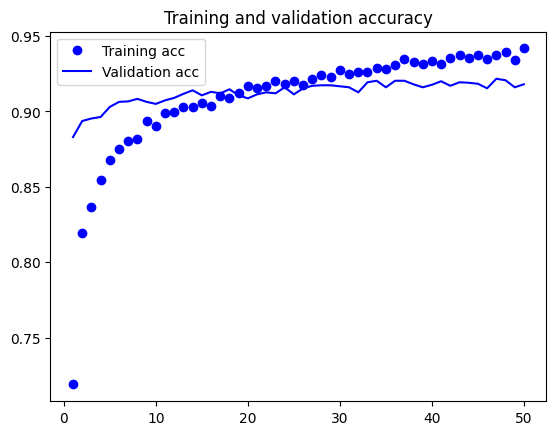

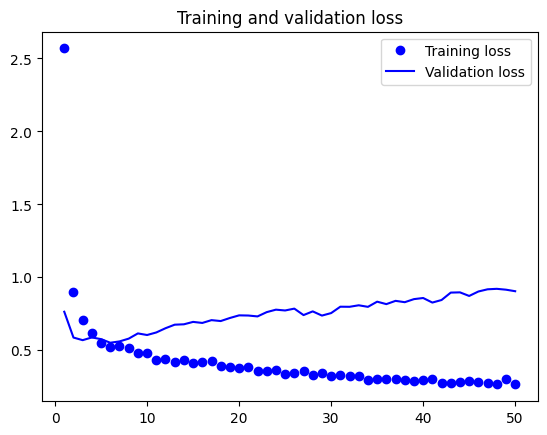

In [ ]:
acc = history_DA.history['accuracy']
val_acc = history_DA.history['val_accuracy']
loss = history_DA.history['loss']
val_loss = history_DA.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

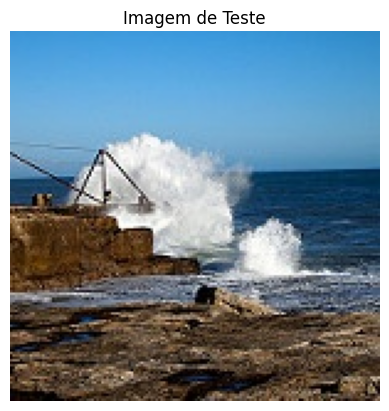

/home/diogo/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
Probabilidades por classe:
 buildings: 0.0000
    forest: 0.0000
   glacier: 0.0000
  mountain: 0.0000
       sea: 1.0000
    street: 0.0000

Classe prevista: sea (1.0000)


In [ ]:
img_path = 'Dataset/archive/seg_test/sea/20072.jpg'

img = tf.keras.preprocessing.image.load_img(
    img_path,
    target_size=(150, 150),
    interpolation='bilinear'
)

plt.imshow(img)
plt.axis('off')
plt.title("Imagem de Teste")
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

result = model_DA.predict(img_array)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print("Probabilidades por classe:")
for i, prob in enumerate(result[0]):
    print(f"{class_names[i]:>10s}: {prob:.4f}")

predicted_class = np.argmax(result)
print(f"\nClasse prevista: {class_names[predicted_class]} ({result[0][predicted_class]:.4f})")


## Comparação dos modelos utilizando a accuracy

In [ ]:
val_loss, val_acc = full_model.evaluate(validation_dataset)
val_loss_t_DA, val_acc_DA = model_DA.evaluate(validation_dataset)


print("Validation Accuracy dos modelos:")
print(f"Model feature extraction: {val_acc:.4f}")
print(f"Model feature extraction + Data augmentation: {val_acc_DA:.4f}")


results = {
    'Without data augmentation': val_acc,
    'With data augmentation': val_acc_DA,
}

# Identificar o melhor modelo com base na maior val_accuracy
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

print(f"\nMelhor modelo: {best_model} com val_accuracy = {best_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9155 - loss: 1.2081
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9121 - loss: 0.5651
Validation Accuracy dos modelos:
Model feature extraction: 0.9187
Model feature extraction + Data augmentation: 0.9063

Melhor modelo: Without data augmentation com val_accuracy = 0.9187


## Calcular saída do modelo para uma imagem

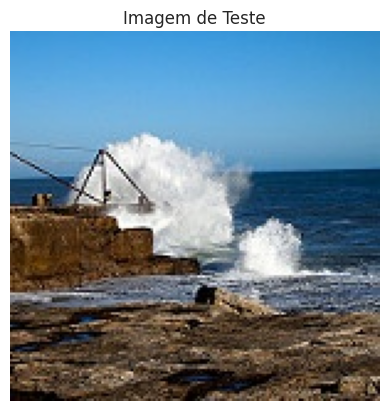

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probabilidades por classe:
 buildings: 0.0000
    forest: 0.0000
   glacier: 0.0000
  mountain: 0.0000
       sea: 1.0000
    street: 0.0000

Classe prevista: sea (1.0000)


In [ ]:
img_path = 'Dataset/archive/seg_test/sea/20072.jpg'

img = tf.keras.preprocessing.image.load_img(
    img_path,
    target_size=(150, 150),
    interpolation='bilinear'
)

plt.imshow(img)
plt.axis('off')
plt.title("Imagem de Teste")
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

result = model_DA.predict(img_array)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print("Probabilidades por classe:")
for i, prob in enumerate(result[0]):
    print(f"{class_names[i]:>10s}: {prob:.4f}")


predicted_class = np.argmax(result)
print(f"\nClasse prevista: {class_names[predicted_class]} ({result[0][predicted_class]:.4f})")

